In [1]:
# basics + plotting
import os, sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# custom
PROJECT_PATH = '/'.join(os.getcwd().split('/')[:-1])
sys.path.insert(1, PROJECT_PATH)

from utils import (
    data_utils, 
    eval_utils, 
    plotting_utils, 
    train_test_utils
)

from models import (
    mlp
)

In [2]:
import importlib
mlp = importlib.reload(mlp)
data_utils = importlib.reload(data_utils)
eval_utils = importlib.reload(eval_utils)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
data = data_utils.load_variation_dataset("../data/data/", 
                                         "../gene_list.txt", 
                                         ["seq-var-matrix"], 
                                         "../data/phenotypes_hcm_only.parquet",
                                         predict = ["hcm"], low_memory=False)

Fetching FHL1 data ... Done
Fetching ACTC1 data ... Done
Fetching ACTN2 data ... Done
Fetching CSRP3 data ... Done
Fetching MYBPC3 data ... Done
Fetching MYH6 data ... Done
Fetching MYH7 data ... Done
Fetching MYL2 data ... Done
Fetching MYL3 data ... Done
Fetching MYOZ2 data ... Done
Fetching LDB3 data ... Done
Fetching TCAP data ... Done
Fetching TNNC1 data ... Done
Fetching TNNI3 data ... Done
Fetching TNNT2 data ... Done
Fetching TPM1 data ... Done
Fetching TRIM63 data ... Done
Fetching PLN data ... Done
Fetching JPH2 data ... Done
Fetching FLNC data ... Done
Fetching ALPK3 data ... Done
Fetching LMNA data ... Done
Fetching NEXN data ... Done
Fetching VCL data ... Done
Fetching MYOM2 data ... Done
Fetching CASQ2 data ... Done
Fetching CAV3 data ... Done
Fetching MYLK2 data ... Done
Fetching CRYAB data ... Done
Combining tables ... Done
Integrating with phenotypes data ...Done


In [5]:
train_dataset, test_dataset = data.train_test_split(balance_on=['hcm','ethnicity'])

In [6]:
def train_epoch(model, train_loader, optimizer, loss_fn, log_every=10):
    model.train()
    total_loss = 0
    
    all_labels, all_preds = [],[]
    for i, batch in enumerate(train_loader):
        # move batch dictionary to device
        data_utils.batch_dict_to_device(batch, device)
        labels, features = batch['labels'], batch['seq-var-matrix']
        
        # compute prediction and loss
        preds = model(features)
        loss = loss_fn(preds, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tracking
        total_loss += loss.item()
        all_labels.append(labels.cpu())
        all_preds.append(preds.flatten().detach().cpu())
        
        # logging
        if (i % log_every == 0):
            print(f"\tBatch {i} | BCE Loss: {loss.item():.4f}")
    
    
    
    metrics = eval_utils.get_metrics(torch.cat(all_labels), 
                                     torch.cat(all_preds))
    metrics['loss'] = total_loss
    
    return metrics

def test(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0
    all_labels, all_preds = [],[]
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # move batch dictionary to device
            data_utils.batch_dict_to_device(batch, device)
            labels, features = batch['labels'], batch['seq-var-matrix']

            # compute prediction and loss
            preds = model(features)
            loss = loss_fn(preds, labels)

            # tracking
            total_loss += loss.item()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.flatten().detach().cpu())
    
    metrics = eval_utils.get_metrics(torch.cat(all_labels), 
                                     torch.cat(all_preds))
    metrics['loss'] = total_loss
    
    return metrics

def train(model, 
          train_dataset,
          test_dataset, 
          lr=1e-3, 
          n_epochs=10,
          batch_size=256):
    
    train_loader = DataLoader(
        dataset = train_dataset, 
        batch_size = batch_size,
        sampler = WeightedRandomSampler(train_dataset.weights('hcm', 
                                                              flatten_factor=0.75), 
                                        num_samples = len(train_dataset)),
        num_workers=12
    )

    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = batch_size,
        num_workers=12
    )
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    
    track_metrics = {'train':{i:None for i in range(n_epochs)}, 
                     'test': {i:None for i in range(n_epochs)}}
    
    for epoch in range(n_epochs):
        print(f"Epoch #{epoch}:")
        train_metrics = train_epoch(model, 
                                    test_loader, 
                                    optimizer, 
                                    loss_fn, 
                                    log_every=10)
        print("Train metrics:")
        eval_utils.print_metrics(train_metrics)
        test_metrics = test(model, 
                            test_loader, 
                            loss_fn)
        print("Test metrics:")
        eval_utils.print_metrics(test_metrics)
        
        track_metrics['train'][epoch] = train_metrics
        track_metrics['test'][epoch] = test_metrics
    
    return track_metrics
    

In [7]:
params = json.load(open("../params/mlp.json"))
params['model_params']['in_dim'] = train_dataset.dataset.summary.loc['all', 'length']
model = mlp.MLP(**params['model_params'])


In [8]:
model


MLP(
  (fc): Sequential(
    (0): Linear(in_features=12339, out_features=1, bias=True)
  )
)

In [55]:
model_metrics = train(model, 
                      train_dataset,
                      test_dataset, 
                      lr=1e-3, 
                      n_epochs=20,
                      batch_size=256)



Epoch #0:
	Batch 0 | BCE Loss: 0.6800
	Batch 10 | BCE Loss: 0.6296
	Batch 20 | BCE Loss: 0.5853
	Batch 30 | BCE Loss: 0.5423
	Batch 40 | BCE Loss: 0.5059
	Batch 50 | BCE Loss: 0.4605
	Batch 60 | BCE Loss: 0.4300
	Batch 70 | BCE Loss: 0.3985
	Batch 80 | BCE Loss: 0.3826
	Batch 90 | BCE Loss: 0.3542
	Batch 100 | BCE Loss: 0.3474
	Batch 110 | BCE Loss: 0.3142
	Batch 120 | BCE Loss: 0.3043
	Batch 130 | BCE Loss: 0.2780
	Batch 140 | BCE Loss: 0.2571
	Batch 150 | BCE Loss: 0.2518
	Batch 160 | BCE Loss: 0.2412
	Batch 170 | BCE Loss: 0.2279
	Batch 180 | BCE Loss: 0.2322
	Batch 190 | BCE Loss: 0.2202
Train metrics:
	accuracy: 0.996
	precision: 0.000
	recall: 0.000
	f1: 0.000
	AUROC: 0.461
	loss: 72.667
Test metrics:
	accuracy: 0.996
	precision: 0.000
	recall: 0.000
	f1: 0.000
	AUROC: 0.513
	loss: 39.698
Epoch #1:
	Batch 0 | BCE Loss: 0.2002
	Batch 10 | BCE Loss: 0.1907
	Batch 20 | BCE Loss: 0.1882
	Batch 30 | BCE Loss: 0.1833
	Batch 40 | BCE Loss: 0.1741
	Batch 50 | BCE Loss: 0.1539
	Batch 60 |

KeyboardInterrupt: 

In [36]:
def plot_metrics(metrics, axes):
    metric_types = list(metrics['train'][0].keys())
    for mt,ax in zip(metric_types, axes.flatten()):
        ax.plot([x[mt] for x in model_metrics['train'].values()])
        ax.plot([x[mt] for x in model_metrics['test'].values()])
        ax.set_title(mt)
    axes[0,0].legend(['train', 'test'])

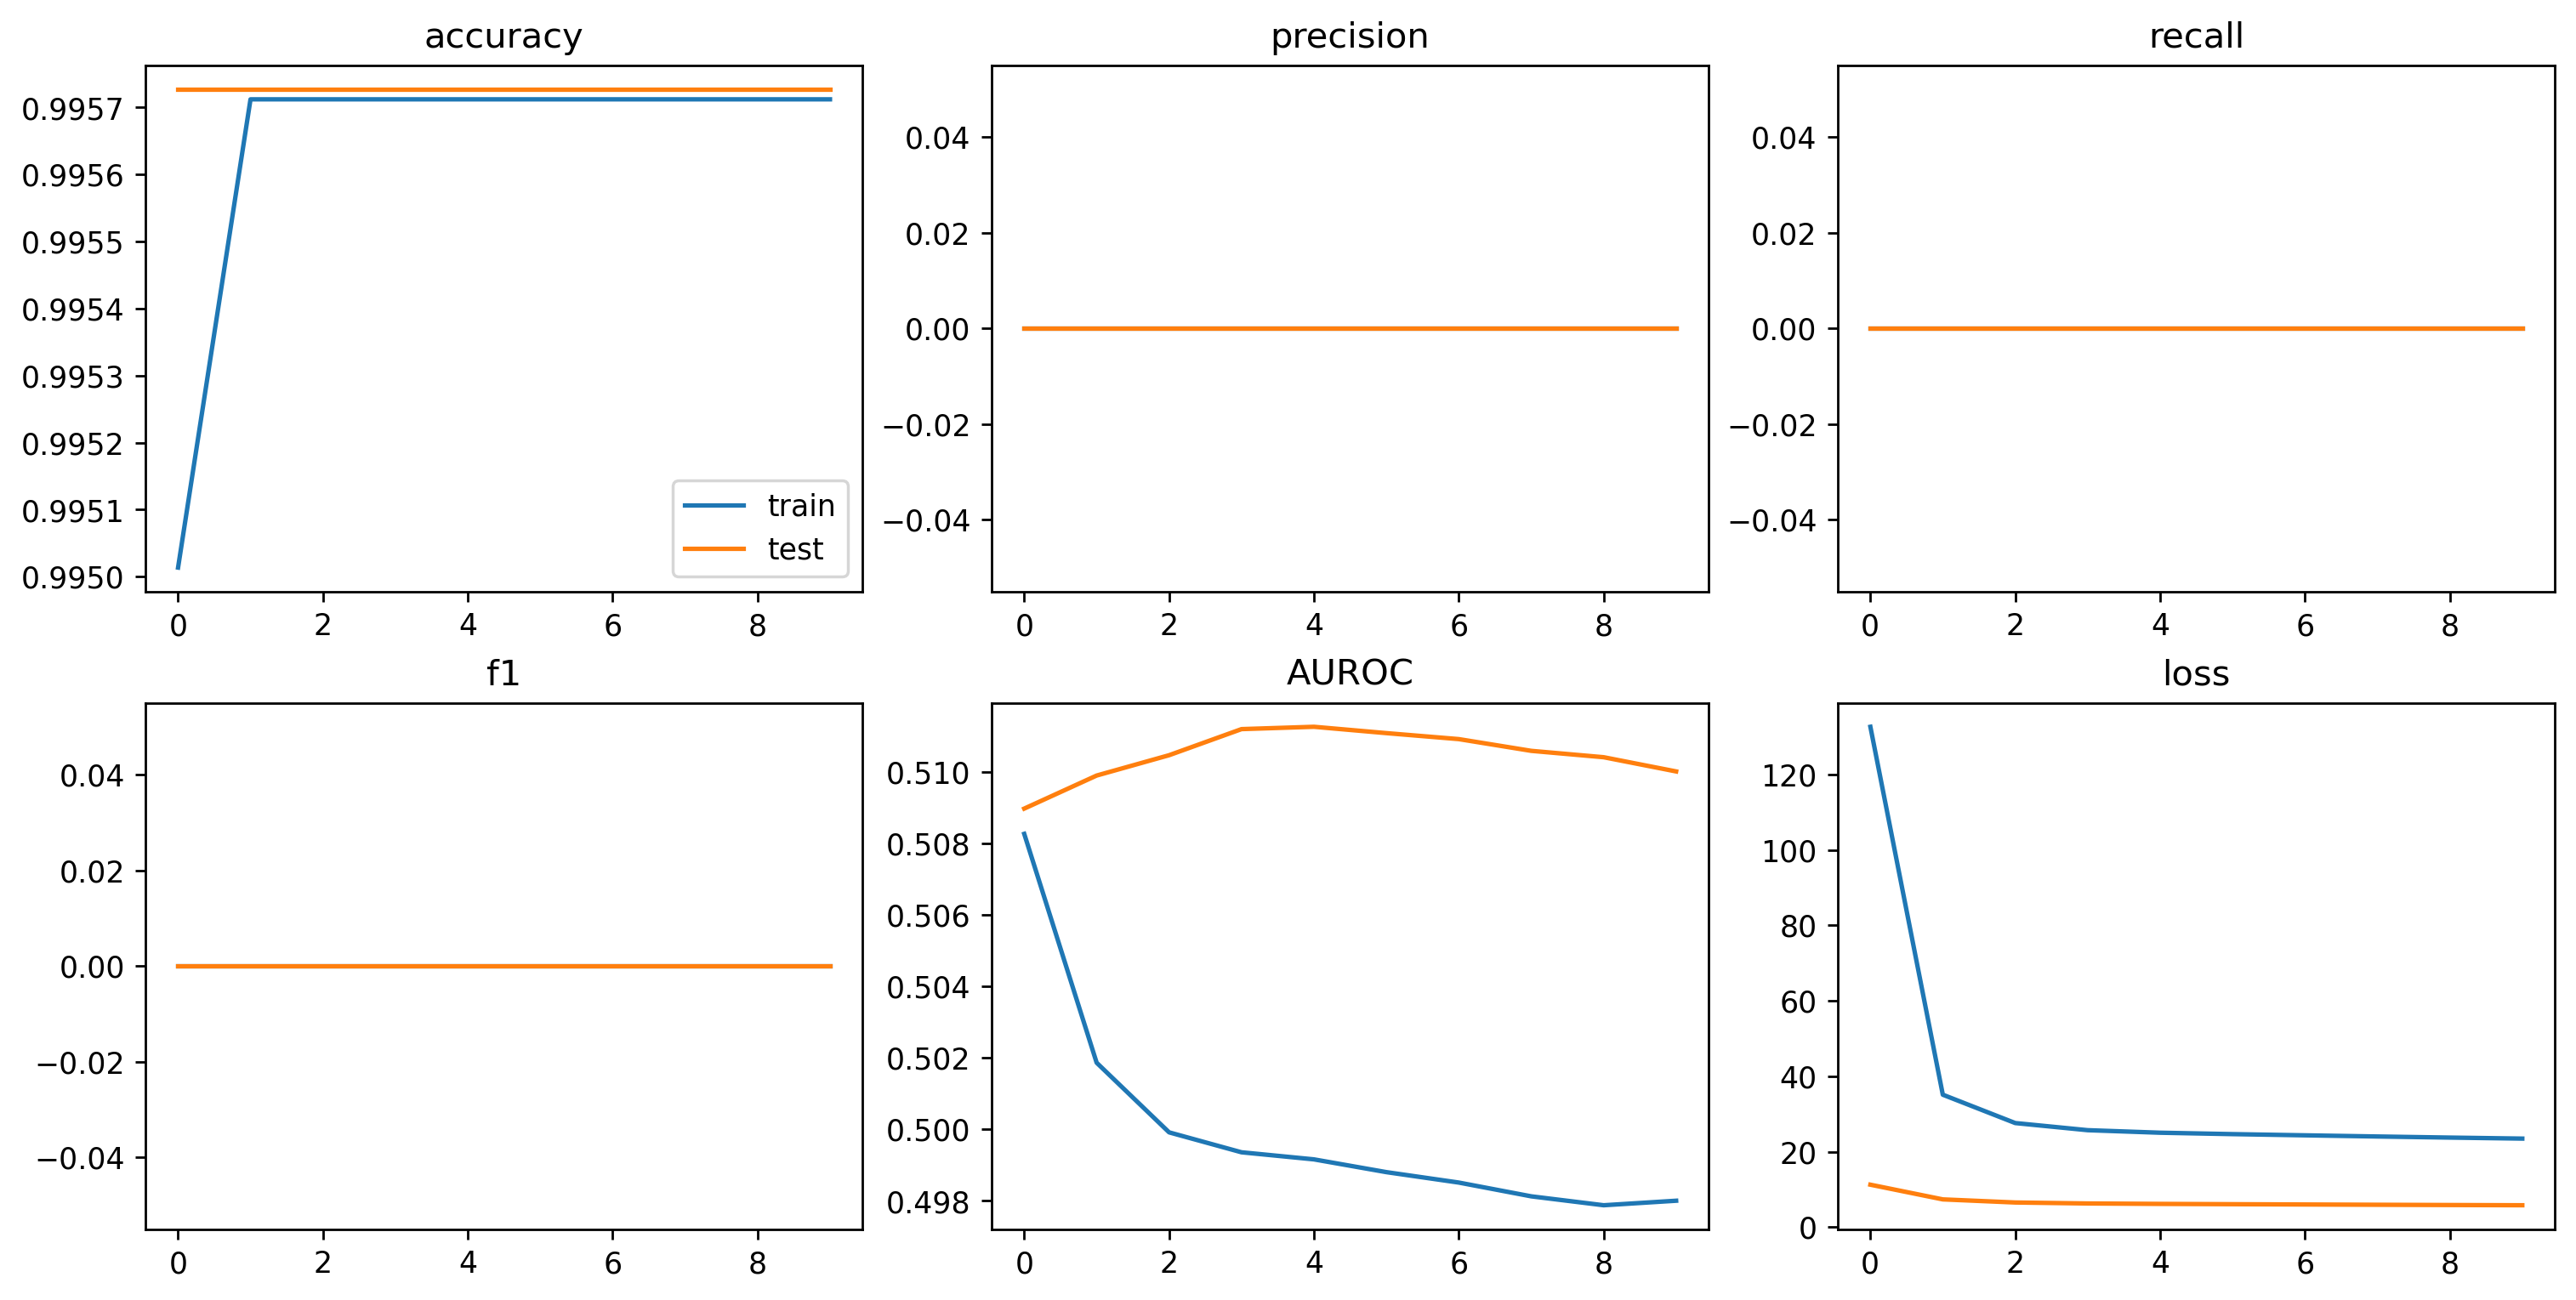

In [43]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)

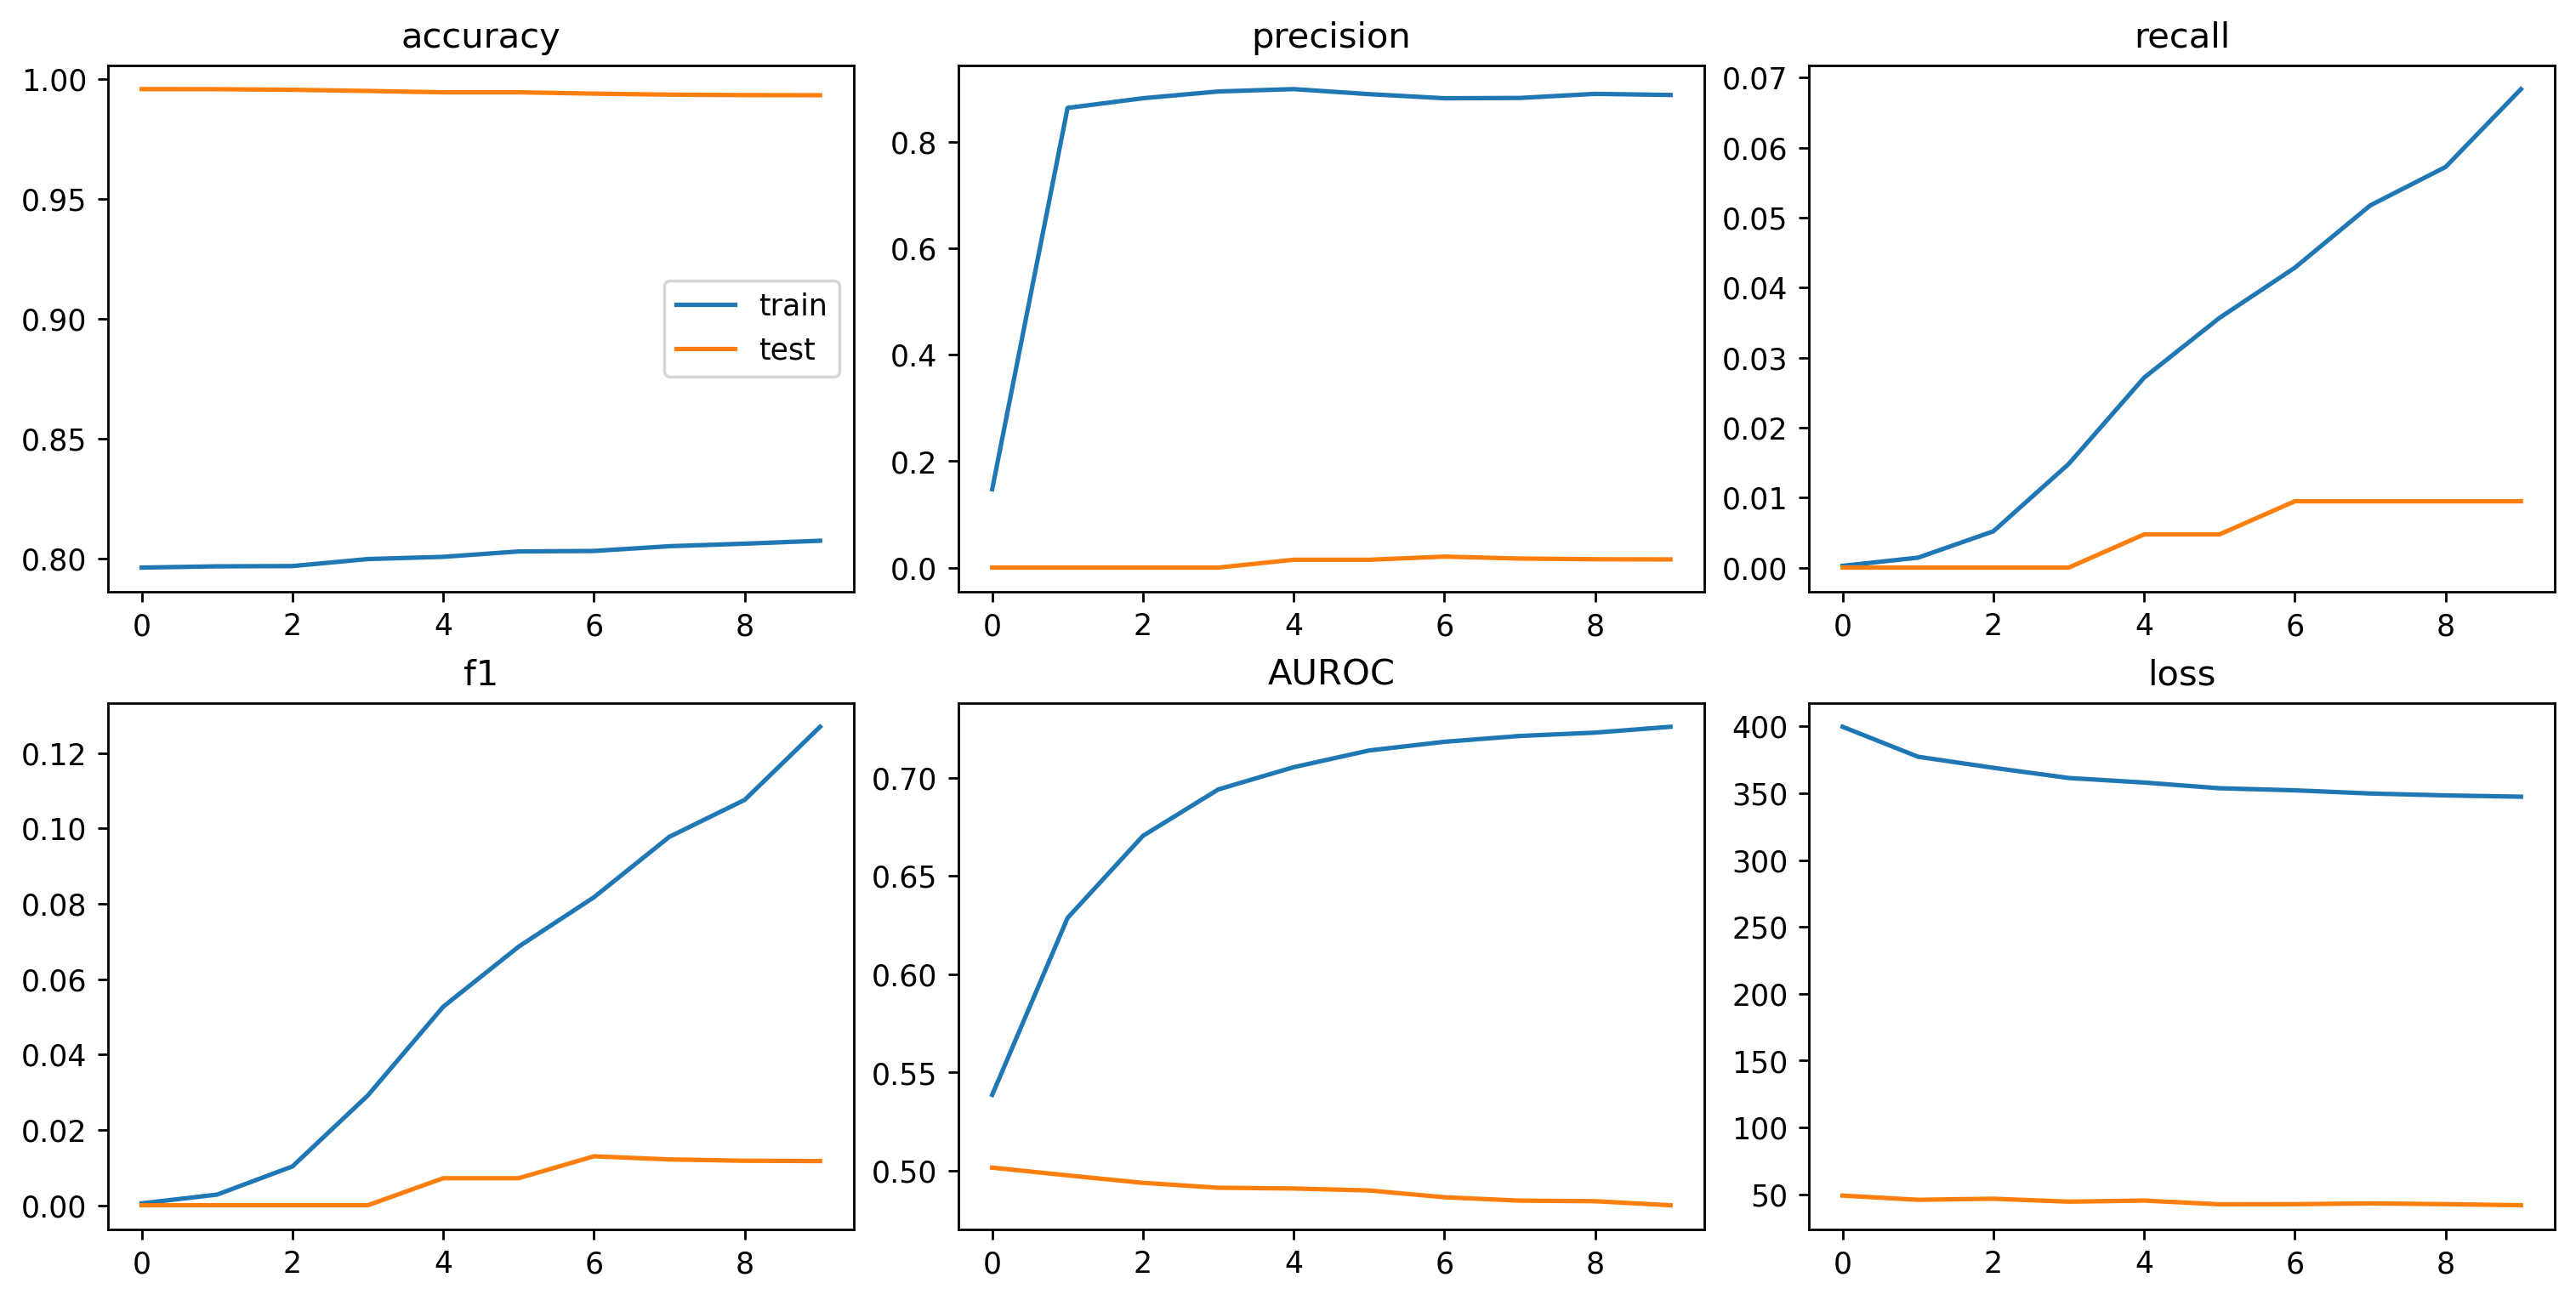

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)
# fig.savefig('../figures/mlp_simple_flatten_factor=1.png')

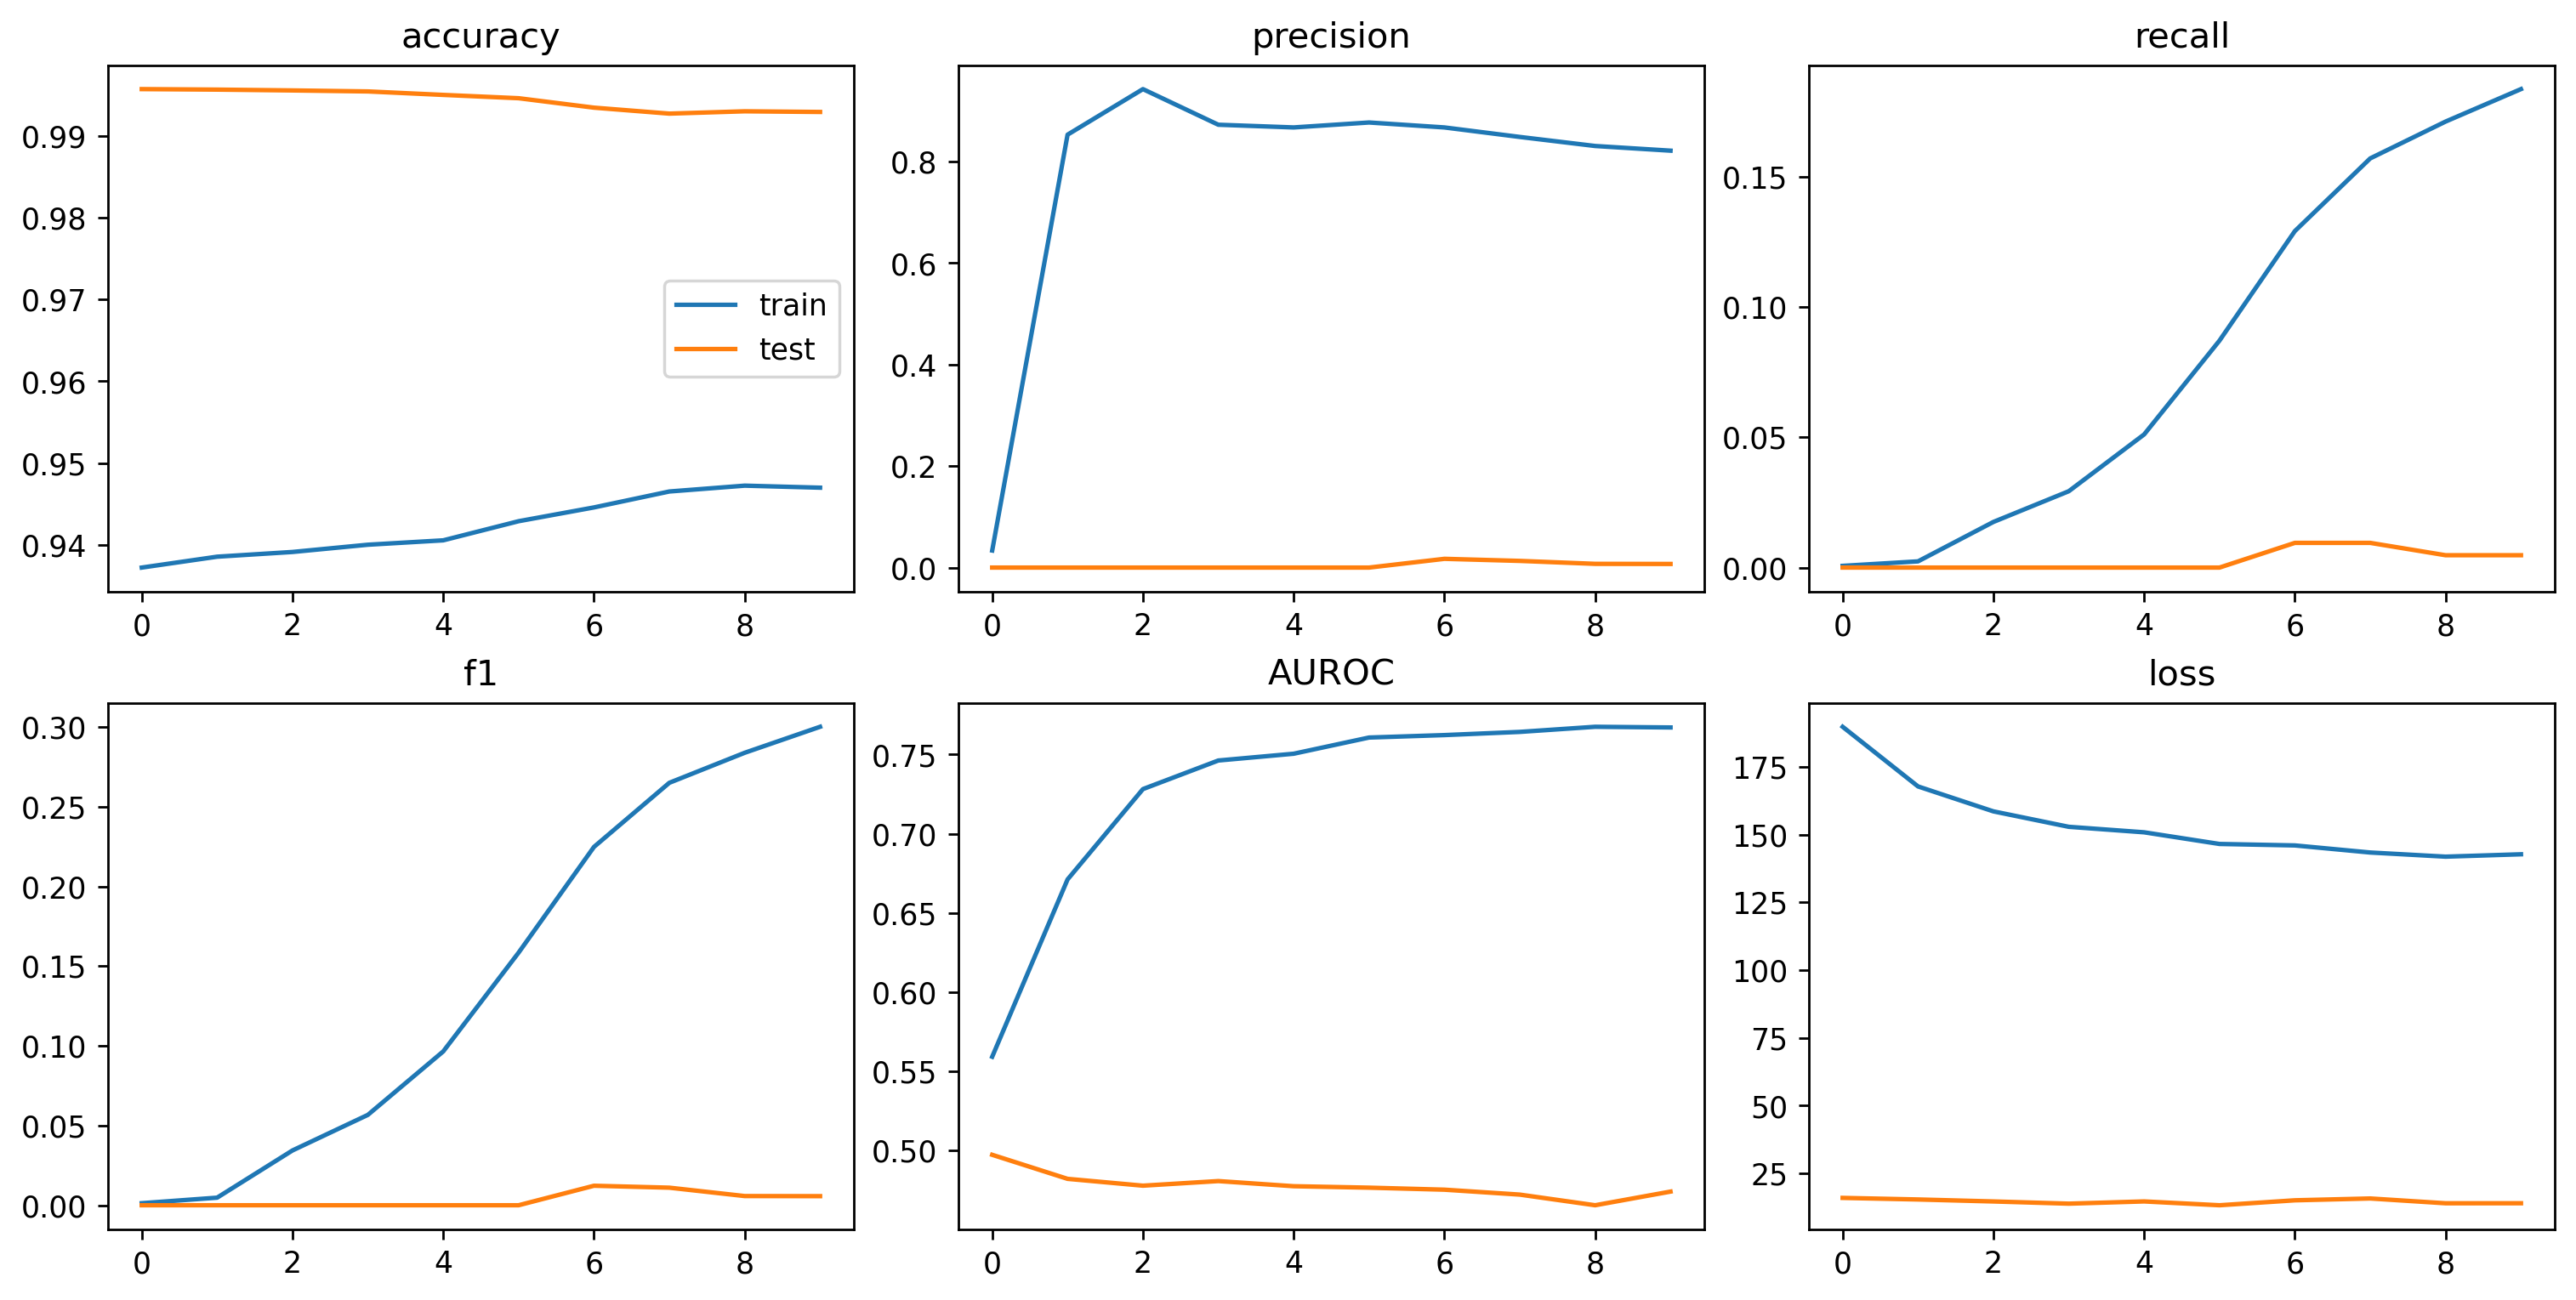

In [16]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)
fig.savefig('../figures/lr_initial.png')